In [51]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [52]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [54]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [55]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

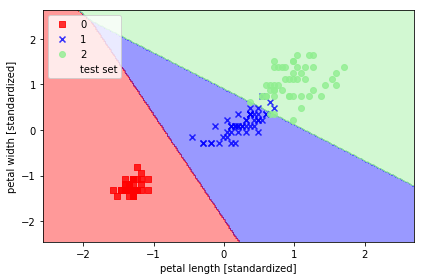

In [56]:
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

## TensorFlow implementation

In [57]:
import tensorflow as tf
tf.set_random_seed(777)  # for reproducibility

In [58]:
x_data = X_train_std.tolist()
y_data = y_train.reshape(-1,1).tolist()

In [59]:
nb_classes = 3  # 0 ~ 6

X = tf.placeholder(tf.float32, [None, 2])
Y = tf.placeholder(tf.int32, [None, 1])  # 0 ~ 6
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot_3:0", shape=(?, 1, 3), dtype=float32)
reshape Tensor("Reshape_15:0", shape=(?, 3), dtype=float32)


In [60]:
W = tf.Variable(tf.random_normal([2, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')
feed_dict = {X: x_data, Y: y_data}

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(X, W) + b
hypothesis = tf.nn.softmax(logits)

# Cross entropy cost/loss
cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_one_hot)
cost = 1000*tf.reduce_mean(cost_i) + tf.nn.l2_loss(W)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

In [61]:
prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [62]:
# Launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(4000):
        sess.run(optimizer, feed_dict=feed_dict)
        if step % 500 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict=feed_dict)
            print("Step: {:5}\tLoss: {:.3f}\tAccuracy: {:.2%}".format(step, loss, acc))
    
    pred = sess.run(prediction, feed_dict=feed_dict)

Step:     0	Loss: 16785.883	Accuracy: 69.52%
Step:   500	Loss: 1571.530	Accuracy: 95.24%
Step:  1000	Loss: 1358.509	Accuracy: 95.24%
Step:  1500	Loss: 1474.407	Accuracy: 94.29%
Step:  2000	Loss: 262.176	Accuracy: 96.19%
Step:  2500	Loss: 41845.320	Accuracy: 37.14%
Step:  3000	Loss: 440.076	Accuracy: 95.24%
Step:  3500	Loss: 981.079	Accuracy: 95.24%


In [63]:
def plot_decision_regions_tf(X, y, prediction, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    #x_data = np.array([xx1.ravel(), xx2.ravel()]).T.tolist()
    #Z = tf.Session().run(prediction, feed_dict={X: x_data})
    #Z = Z.reshape(xx1.shape)
    
    #plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

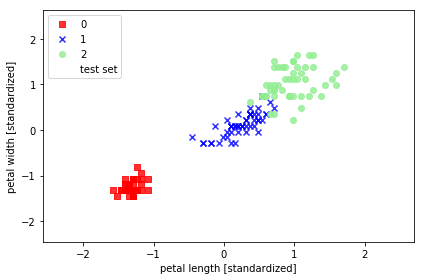

In [64]:
plot_decision_regions_tf(X_combined_std, y_combined, prediction, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

# Keras Implementation

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation

nb_classes = 3

model = Sequential()
model.add(Dense(3, input_shape=(2,)))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x_data, y_data, epochs=1000, verbose=0)

#print(model.predict_classes(np.array([[1, 2, 1, 1]])))
#print(model.predict_classes(np.array([[3,1,3,4]])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 9         
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 9.0
Trainable params: 9.0
Non-trainable params: 0.0
_________________________________________________________________


ValueError: Error when checking model target: expected activation_2 to have shape (None, 3) but got array with shape (105, 1)